In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ['/public/home/mowp/test/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import re
import pysam
import pyBigWig
import math
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
from scipy.signal import savgol_filter

In [3]:
infile = '/data/Zhaijx/mowp/db/col-CEN/bed/cen_region.bed'
cen_region = {}
with open(infile, 'r') as f:
    for line in f:
        line = line.strip().split('\t')
        cen_region[line[0]] = int(line[1]), int(line[2])

In [4]:
def strand_specific_aggregate(
    infile: str, 
    chrom: str, start: int, end: int):

    methylated_results, all_results = Counter(), Counter()
    tbx = pysam.TabixFile(infile)
    for line in tbx.fetch(chrom, start, end):
        read_id, mod, _chrom, _start, _end, strand, methylated_pos, unmethylated_pos = line.split('\t')

        methylated_pos = np.fromstring(methylated_pos, sep=',', dtype=int)
        unmethylated_pos = np.fromstring(unmethylated_pos, sep=',', dtype=int)

        for pos in methylated_pos:
            methylated_results[(chrom, pos, strand)] += 1
            all_results[(chrom, pos, strand)] += 1
        for pos in unmethylated_pos:
            all_results[(chrom, pos, strand)] += 1
        
    return methylated_results, all_results

In [5]:
def get_bin_stats(infile: str, chrom: str, start: int, end: int, binsize: int = 50_000):
    stats = []
    bw = pyBigWig.open(infile)
    for pos in range(start, end, binsize):
        value = bw.stats(chrom, pos, pos+binsize)
        stats.append(value[0])
    bw.close()
    return stats

In [6]:
def despines(ax, bottom=True, left=True, right=True, top=True, yaxis=True, xaxis=True):
    if bottom:
        ax.spines['bottom'].set_visible(False)
    if left:
        ax.spines['left'].set_visible(False)
    if right:
        ax.spines['right'].set_visible(False)
    if top:
        ax.spines['top'].set_visible(False)
    if yaxis:
        ax.yaxis.set_major_locator(ticker.NullLocator())  # 去y数字
    if xaxis:
        ax.xaxis.set_major_locator(ticker.NullLocator())

In [7]:
chroms, starts, ends= [], [], []
for chrom in cen_region:
    chroms.append(chrom)
    starts.append(cen_region[chrom][0])
    ends.append(cen_region[chrom][1])

# CEN180 direction

In [8]:
# cen180 direction
infile = '/data/Zhaijx/mowp/db/col-CEN/bed/ColCEN_CEN180.bed'
cen180_fwd, cen180_rev = defaultdict(lambda : []), defaultdict(lambda : [])
initialization = True
with open(infile, 'r') as f:
    for line in f:
        chrom, start, end, *_, strand = line.rstrip().split('\t')
        start = int(start)
        end = int(start)
        
        if initialization:
            initialization = False
            last_chrom, last_start, last_end, last_strand = chrom, start, end, strand

        if last_chrom != chrom:
            last_chrom = chrom
            last_strand = strand

        if last_strand != strand:
            if last_strand == '+':
                cen180_fwd[chrom].append([None, None])
            else:
                cen180_rev[chrom].append([None, None])
            last_strand = strand

        if strand == '+':
            if len(cen180_fwd[chrom]) == 0:
                cen180_fwd[chrom].append([start, end])
            else:
                if cen180_fwd[chrom][-1][0] is not None:
                    cen180_fwd[chrom][-1][1] = end
                else:
                    cen180_fwd[chrom][-1][0] = start
                    cen180_fwd[chrom][-1][1] = end
        else:
            if len(cen180_rev[chrom]) == 0:
                cen180_rev[chrom].append([start, end])
            else:
                if cen180_rev[chrom][-1][0] is not None:
                    cen180_rev[chrom][-1][1] = end
                else:
                    cen180_rev[chrom][-1][0] = start
                    cen180_rev[chrom][-1][1] = end
cen180_fwd = dict(cen180_fwd)
cen180_rev = dict(cen180_rev)

In [9]:
cen180_fwd_range, cen180_rev_range = {}, {}

for chrom in cen180_fwd:

    ranges = []
    for _range in cen180_fwd[chrom]:
        if _range[0] is not None:
            start, end = _range[0], _range[1]
            if start < cen_region[chrom][0]:
                start = cen_region[chrom][0]
            if end > cen_region[chrom][1]:
                end = cen_region[chrom][1]

            size = end - start
            if size > 0:
                ranges.append((start, size))
    cen180_fwd_range[chrom] = ranges

    ranges = []
    for _range in cen180_rev[chrom]:
        if _range[0] is not None:
            start, end = _range[0], _range[1]
            if start < cen_region[chrom][0]:
                start = cen_region[chrom][0]
            if end > cen_region[chrom][1]:
                end = cen_region[chrom][1]

            size = end - start
            if size > 0:
                ranges.append((start, size))
    cen180_rev_range[chrom] = ranges

## Results

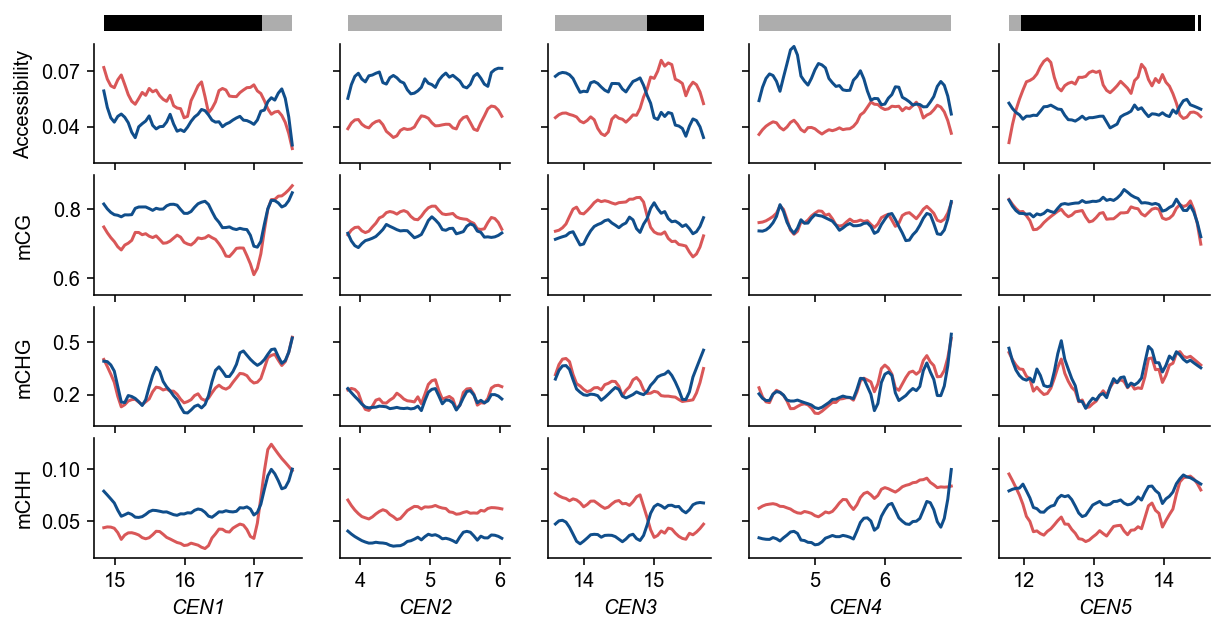

In [10]:
infile_fwd_list = [
    '/data/Zhaijx/mowp/data/stam_seq_col_CEN/analysis/strand_specific_analysis/20221029_col_m6A.m6A_fwd.bw',
    '/data/Zhaijx/mowp/data/stam_seq_col_CEN/analysis/strand_specific_analysis/20221029_col_m6A.mCG_fwd.bw',
    '/data/Zhaijx/mowp/data/stam_seq_col_CEN/analysis/strand_specific_analysis/20221029_col_m6A.mCHG_fwd.bw',
    '/data/Zhaijx/mowp/data/stam_seq_col_CEN/analysis/strand_specific_analysis/20221029_col_m6A.mCHH_fwd.bw',
]

infile_rev_list = [
    '/data/Zhaijx/mowp/data/stam_seq_col_CEN/analysis/strand_specific_analysis/20221029_col_m6A.m6A_rev.bw',
    '/data/Zhaijx/mowp/data/stam_seq_col_CEN/analysis/strand_specific_analysis/20221029_col_m6A.mCG_rev.bw',
    '/data/Zhaijx/mowp/data/stam_seq_col_CEN/analysis/strand_specific_analysis/20221029_col_m6A.mCHG_rev.bw',
    '/data/Zhaijx/mowp/data/stam_seq_col_CEN/analysis/strand_specific_analysis/20221029_col_m6A.mCHH_rev.bw',
]

filetypes = ['Accessibility', 'mCG', 'mCHG', 'mCHH']

width_ratios = []
for v in cen_region.values():
    size = v[1] - v[0]
    width_ratios.append(size / 1e6)

height_ratios = [1.5] + [10] * len(infile_fwd_list)


binsize = 50_000
fig, ax = plt.subplots(
    ncols=len(cen_region), nrows=1+len(infile_fwd_list), figsize=(10, 5), 
    sharey='row',
    gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})

yticks = [
    [0.04, 0.07],
    [.6, .8],
    [.2, .5],
    [.05, .1]
]

ylims = [
    [.02, 0.085],
    [.55, .9],
    [.02, .7],
    [.015, .13]
]

col = 0
for infile_fwd, infile_rev, _filetype, ytick, ylim in zip(infile_fwd_list, infile_rev_list, filetypes, yticks, ylims):
    col += 1
    for idx, chrom in enumerate(cen_region):
        start, end = cen_region[chrom]
        fwd_stats = get_bin_stats(infile_fwd, chrom, start, end, binsize=binsize)
        rev_stats = get_bin_stats(infile_rev, chrom, start, end, binsize=binsize)

        ax[col][idx].plot(savgol_filter(fwd_stats, 7, 2), color='#d95758')
        ax[col][idx].plot(savgol_filter(rev_stats, 7, 2), color='#104e8b')

        _start, _end = math.ceil(cen_region[chrom][0] / 1_000_000), math.ceil(cen_region[chrom][1] / 1_000_000)

        xtickslabels = np.arange(_start, _end)
        xticks = (xtickslabels*1_000_000-start) / binsize
        ax[col][idx].set_xticks(xticks)
        ax[col][idx].set_xticklabels(xtickslabels)
        ax[col][idx].set_xlabel(f'CEN{idx+1}', fontstyle='italic')
        despines(ax[col][idx], yaxis=False, xaxis=False, bottom=False, left=False)
        ax[col][0].set_ylabel(_filetype)
        ax[col][0].set_yticks(ytick)
        ax[col][0].set_ylim(ylim)


for idx, chrom in enumerate(cen_region):
    ax[0][idx].broken_barh(cen180_fwd_range[chrom], (0, .1), facecolors='k', edgecolor=None)
    ax[0][idx].broken_barh(cen180_rev_range[chrom], (0, .1), facecolors='#ADADAD', edgecolor=None)
    despines(ax[0][idx])

fig.align_ylabels(ax[:, 0])  # align y labels
plt.subplots_adjust(hspace=.12)